# Import Dependencies

In [72]:
# Cell 1: Import Necessary Libraries

import os
import json
import gzip
import re
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Download Turkish stopwords
nltk.download('stopwords')
TURKISH_STOPWORDS = stopwords.words('turkish')

# Define additional stopwords specific to the dataset
ADDITIONAL_STOPWORDS = ["bir", "gibi", "olarak", "çok", "daha", "ve", "bu"]
UPDATED_STOPWORDS = TURKISH_STOPWORDS + ADDITIONAL_STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\itsmm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
# Cell 2: Define Repository Structure and Data Paths

# Current Notebook Directory (e.g., "repo/notebooks")
current_notebook_dir = os.getcwd()

# Repository Root Directory (e.g., "repo")
repo_dir = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Data Directory (e.g., "repo/data")
data_dir = os.path.join(repo_dir, 'data')

# Training, Testing, and Output Directories
training_dir = os.path.join(data_dir, 'training')
testing_dir = os.path.join(data_dir, 'testing')
output_dir = os.path.join(data_dir, 'output')

# Ensure that the output directory exists
os.makedirs(output_dir, exist_ok=True)

# File Paths
train_csv_path = os.path.join(training_dir, 'train-classification.csv')
train_jsonl_path = os.path.join(training_dir, 'training-dataset.jsonl.gz')
test_classification_path = os.path.join(testing_dir, 'test-classification-round1.dat')
test_regression_path = os.path.join(testing_dir, 'test-regression-round1.jsonl')

In [74]:
# Cell 3: Load and Preprocess Train Classification Data

def load_train_classification(file_path: str) -> pd.DataFrame:
    """
    Loads and preprocesses the train-classification CSV file.

    Parameters:
    - file_path: Path to the train-classification.csv file.

    Returns:
    - DataFrame with renamed columns and standardized category labels.
    """
    try:
        df = pd.read_csv(file_path)
        df = df.rename(columns={'Unnamed: 0': 'user_id', 'label': 'category'})
        df["category"] = df["category"].str.lower()
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading train classification data: {e}")
        return pd.DataFrame()


# Load the train classification data
df_classification = load_train_classification(train_csv_path)

# Display the first few rows to verify
df_classification.head()

,user_id,category
0,taskirancemal,mom and children
1,tam_kararinda,food
2,spart4nn,food
3,sosyalyiyiciler,food
4,sonaydizdarahad,mom and children


In [75]:
# Cell 4: Create User to Category Mapping

def map_user_to_category(df: pd.DataFrame) -> Dict[str, str]:
    """
    Creates a mapping from user IDs to categories.

    Parameters:
    - df: DataFrame containing 'user_id' and 'category' columns.

    Returns:
    - Dictionary mapping user IDs to categories.
    """
    try:
        return df.set_index("user_id").to_dict()["category"]
    except KeyError:
        print("Columns 'user_id' and/or 'category' not found in DataFrame.")
        return {}
    except Exception as e:  
        print(f"Error mapping user to category: {e}")
        return {}


# Create the mapping
username2_category = map_user_to_category(df_classification)

# Verify the mapping for a sample user
sample_user_id = df_classification['user_id'].iloc[0]
print(f"User ID: {sample_user_id}, Category: {username2_category.get(sample_user_id)}")

User ID: taskirancemal, Category: mom and children


In [76]:
# Cell 5: Segregate Training and Testing Data

def load_training_data(file_path: str, user_category_map: Dict[str, str]) -> Tuple[Dict[str, List[Dict]], Dict[str, Dict]]:
    """
    Loads and segregates training and testing data based on user categories.

    Parameters:
    - file_path: Path to the training-dataset.jsonl.gz file.
    - user_category_map: Dictionary mapping user IDs to categories.

    Returns:
    - Tuple containing:
        - username2posts_train: Dict mapping usernames to their posts for training.
        - username2profile_train: Dict mapping usernames to their profile data for training.
    """
    username2posts_train = {}
    username2profile_train = {}
    username2posts_test = {}
    username2profile_test = {}
    
    try:
        with gzip.open(file_path, "rt", encoding='utf-8') as fh:
            for line_number, line in enumerate(fh, start=1):
                try:
                    sample = json.loads(line)
                    profile = sample.get("profile", {})
                    username = profile.get("username", "").strip()
                    
                    if not username:
                        print(f"Line {line_number}: Missing username. Skipping.")
                        continue
    
                    if username in user_category_map:
                        # Training Data
                        username2posts_train[username] = sample.get("posts", [])
                        username2profile_train[username] = profile
                    else:
                        # Testing Data
                        username2posts_test[username] = sample.get("posts", [])
                        username2profile_test[username] = profile
                except json.JSONDecodeError:
                    print(f"Line {line_number}: JSON decode error. Skipping.")
                except Exception as e:
                    print(f"Line {line_number}: Unexpected error: {e}. Skipping.")
    
        return username2posts_train, username2profile_train, username2posts_test, username2profile_test
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return username2posts_train, username2profile_train, username2posts_test, username2profile_test
    except Exception as e:
        print(f"Error loading training data: {e}")
        return username2posts_train, username2profile_train, username2posts_test, username2profile_test


# Load and segregate the training data
username2posts_train, username2profile_train, username2posts_test, username2profile_test = load_training_data(train_jsonl_path, username2_category)

# Display counts
print(f"Number of Training Users: {len(username2posts_train)}")
print(f"Number of Testing Users: {len(username2posts_test)}")

Number of Training Users: 2741
Number of Testing Users: 2674


In [77]:
# Cell 6: Create DataFrames for User Profiles

def create_profile_dataframe(username2profile: Dict[str, Dict]) -> pd.DataFrame:
    """
    Creates a DataFrame from user profiles.

    Parameters:
    - username2profile: Dict mapping usernames to their profile data.

    Returns:
    - DataFrame containing user profiles.
    """
    try:
        df = pd.DataFrame(username2profile).T.reset_index(drop=True)
        return df
    except Exception as e:
        print(f"Error creating profile DataFrame: {e}")
        return pd.DataFrame()


# Create DataFrames for training and testing profiles
train_profile_df = create_profile_dataframe(username2profile_train)
test_profile_df = create_profile_dataframe(username2profile_test)

# Display the first few rows of the training profile DataFrame
print("Training Profile DataFrame:")
display(train_profile_df.head())

# Display the first few rows of the testing profile DataFrame
print("\nTesting Profile DataFrame:")
display(test_profile_df.head())

Training Profile DataFrame:


,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,deparmedya,3170700063,Depar Medya,#mediaplanning #mediabuying #sosyalmedya,Local business,None,1167,192,True,False,...,None,None,LOCAL,False,False,https://instagram.fsaw2-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,kafesfirin,266439571,KAFES FIRIN,📍Söğütözü📍FTZ AVM\n🛒Ankara macro▲center v...,Brand,None,11997,17,True,False,...,None,None,BRAND,False,False,https://instagram.fada1-13.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,vimerang,2367195567,Vimerang,Dijital İletişim Yönetimi🎬info@vimerang.comq,None,None,2321,454,True,False,...,Creators & Celebrities,None,VIDEO_CREATOR,False,False,https://instagram.fist19-1.fna.fbcdn.net/v/t51...,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,mustafa_yalcinn38,9606564254,Mustafa Yalçın,Talas Belediye Başkanı,Politician,None,13647,29,True,False,...,None,None,POLITICIAN,False,False,https://instagram.fist1-4.fna.fbcdn.net/v/t51....,True,False,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,zorluenergysolutions,8155780357,ZES (Zorlu Energy Solutions),Türkiye’nin 81 ilindeki en yaygın elektrikli ş...,None,None,7917,11,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fayt2-2.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...



Testing Profile DataFrame:


,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,...,business_category_name,overall_category_name,category_enum,is_verified_by_mv4b,is_regulated_c18,profile_pic_url,should_show_category,should_show_public_contacts,show_account_transparency_details,profile_picture_base64
0,beyazyakaliyiz,8634457436,Selam Beyaz Yakalı,Beyaz yakalıların dünyasına hoşgeldiniz 😀😀😀,Personal blog,None,1265,665,True,False,...,None,None,PERSONAL_BLOG,False,False,https://instagram.fist6-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,totalenergies_istasyonlari,7066643793,TotalEnergies İstasyonları,TotalEnergies İstasyonları resmi Instagram hes...,Energy Company,None,28025,4,True,False,...,None,None,ENERGY_COMPANY,False,False,https://instagram.fsaw2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,konforyatak,8782109673,Konfor Yatak #KonforluUykular,"Konfor Yatak, birbirinden farklı özelliklere s...",Furniture,None,40334,2,True,False,...,None,None,FURNITURE,False,False,https://instagram.fyei6-3.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,ht_kulup,1950140344,HT KULÜP,Bloomberght - Habertürk Magazin,None,None,158877,69,True,False,...,None,None,TV_SHOW,False,False,https://instagram.fada2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,ajansspor,338611487,Ajansspor,"🏢 Saran Group \n🏟 Anında, tarafsız spor haberl...",News & media website,None,93193,286,True,False,...,None,None,NEWS_SITE,False,False,https://instagram.fadb2-1.fna.fbcdn.net/v/t51....,True,True,True,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [78]:
# Cell 7: Initial Data Exploration and Verification

def initial_data_exploration(train_class_df: pd.DataFrame, train_profile_df: pd.DataFrame, test_profile_df: pd.DataFrame):
    """
    Performs initial data exploration and visualization.

    Parameters:
    - train_class_df: DataFrame containing training classification data.
    - train_profile_df: DataFrame containing training profile data.
    - test_profile_df: DataFrame containing testing profile data.
    """
    try:
        print("\n=== Class Distribution ===")
        class_counts = train_class_df['category'].value_counts()
        print(class_counts)
        
        print("\n=== Training Profile DataFrame Statistics ===")
        print(train_profile_df.describe(include='all'))
        
        print("\n=== Testing Profile DataFrame Statistics ===")
        print(test_profile_df.describe(include='all'))
        
        print("\n=== Missing Values in Training Classification DataFrame ===")
        print(train_class_df.isnull().sum())
        
        print("\n=== Missing Values in Training Profile DataFrame ===")
        print(train_profile_df.isnull().sum())
        
        print("\n=== Missing Values in Testing Profile DataFrame ===")
        print(test_profile_df.isnull().sum())
        
        # Additional exploration can be added here (e.g., unique values, value distributions)
    except Exception as e:
        print(f"Error during initial data exploration: {e}")


# Perform initial data exploration
initial_data_exploration(df_classification, train_profile_df, test_profile_df)


=== Class Distribution ===
category
food                    511
health and lifestyle    503
tech                    346
entertainment           323
fashion                 299
travel                  294
art                     191
mom and children        149
sports                  113
gaming                   13
Name: count, dtype: int64

=== Training Profile DataFrame Statistics ===
          username          id    full_name     biography    category_name  \
count         2741        2741         2715          2571             2226   
unique        2741        2741         2715          2565              333   
top     deparmedya  3170700063  Depar Medya  @bigbosslayf  Product/service   
freq             1           1            1             2              178   

        post_count  follower_count  following_count is_business_account  \
count        275.0            2741             2741                2741   
unique       259.0            2654              986                  

In [79]:
# Cell 8: Handle Missing Values

def handle_missing_values(df_classification: pd.DataFrame, 
                         df_train_profile: pd.DataFrame, 
                         df_test_profile: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Identifies and handles missing values in the classification and profile DataFrames.
    
    Parameters:
    - df_classification: DataFrame containing user classifications.
    - df_train_profile: DataFrame containing training user profiles.
    - df_test_profile: DataFrame containing testing user profiles.
    
    Returns:
    - Tuple of DataFrames with missing values handled.
    """
    # Handling missing values in classification DataFrame
    print("\nHandling Missing Values in Classification DataFrame:")
    missing_class = df_classification.isnull().sum()
    print(missing_class)
    
    # If 'category' has missing values, decide whether to drop or impute
    if missing_class['category'] > 0:
        print(f"\nNumber of missing 'category' values: {missing_class['category']}")
        # Option 1: Drop rows with missing 'category'
        df_classification = df_classification.dropna(subset=['category'])
        print(f"After dropping, new shape: {df_classification.shape}")
    
    # Handling missing values in training profile DataFrame
    print("\nHandling Missing Values in Training Profile DataFrame:")
    missing_train_profile = df_train_profile.isnull().sum()
    print(missing_train_profile)
    
    # Example Strategy: Fill missing numerical values with median and categorical with mode
    numerical_cols_train = df_train_profile.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols_train = df_train_profile.select_dtypes(include=['object']).columns
    
    for col in numerical_cols_train:
        median = df_train_profile[col].median()
        df_train_profile[col] = df_train_profile[col].fillna(median)  # Reassign after filling
    
    for col in categorical_cols_train:
        mode = df_train_profile[col].mode()[0] if not df_train_profile[col].mode().empty else 'unknown'
        df_train_profile[col] = df_train_profile[col].fillna(mode)  # Reassign after filling
        # Ensure correct dtype
        df_train_profile[col] = df_train_profile[col].infer_objects()
    
    # Handling missing values in testing profile DataFrame
    print("\nHandling Missing Values in Testing Profile DataFrame:")
    missing_test_profile = df_test_profile.isnull().sum()
    print(missing_test_profile)
    
    numerical_cols_test = df_test_profile.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols_test = df_test_profile.select_dtypes(include=['object']).columns
    
    for col in numerical_cols_test:
        median = df_test_profile[col].median()
        df_test_profile[col] = df_test_profile[col].fillna(median)  # Reassign after filling
    
    for col in categorical_cols_test:
        mode = df_test_profile[col].mode()[0] if not df_test_profile[col].mode().empty else 'unknown'
        df_test_profile[col] = df_test_profile[col].fillna(mode)  # Reassign after filling
        # Ensure correct dtype
        df_test_profile[col] = df_test_profile[col].infer_objects()
    
    return df_classification, df_train_profile, df_test_profile

# Handle missing values
df_classification, train_profile_df, test_profile_df = handle_missing_values(df_classification, train_profile_df, test_profile_df)

# Verify that there are no missing values left
print("\nVerification of Missing Values After Handling:")
print("Classification DataFrame Missing Values:")
df_classification.isnull().sum()

print("\nTraining Profile DataFrame Missing Values:")
print(train_profile_df.isnull().sum())

print("\nTesting Profile DataFrame Missing Values:")
print(test_profile_df.isnull().sum())


Handling Missing Values in Classification DataFrame:
user_id     0
category    0
dtype: int64

Handling Missing Values in Training Profile DataFrame:
username                                0
id                                      0
full_name                              26
biography                             170
category_name                         515
post_count                           2466
follower_count                          0
following_count                         0
is_business_account                     0
is_private                              0
is_verified                             0
highlight_reel_count                    0
bio_links                               0
entities                              170
ai_agent_type                        2741
fb_profile_biolink                   2741
restricted_by_viewer                 2741
country_block                           0
eimu_id                                 0
external_url                          457
fbid     

C:\Users\itsmm\AppData\Local\Temp\ipykernel_13712\102826033.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train_profile[col] = df_train_profile[col].fillna(mode)  # Reassign after filling
C:\Users\itsmm\AppData\Local\Temp\ipykernel_13712\102826033.py:62: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test_profile[col] = df_test_profile[col].fillna(mode)  # Reassign after filling


In [80]:
# Cell 9.1: Define Columns to Exclude from Encoding

# Columns that should NOT be encoded and should be removed
COLUMNS_TO_REMOVE = [
    'ai_agent_type', 'fb_profile_biolink', 'restricted_by_viewer', 'country_block', 'eimu_id', 
    'external_url', 'fbid', 'is_supervision_enabled', 'is_guardian_of_viewer', 'is_supervised_by_viewer', 
    'is_supervised_user', 'is_embeds_disabled', 'is_joined_recently', 'business_address_json', 
    'business_email', 'business_phone_number', 'category_enum', 'is_verified_by_mv4b', 'is_regulated_c18', 
    'profile_pic_url', 'should_show_category', 'should_show_public_contacts', 'show_account_transparency_details', 
    'profile_picture_base64',
    'overall_category_name', 'highlight_reel_count', 'bio_links', 'entities', 'has_clips', 'business_contact_method'
]

# Cell 9.2: Update the Encoding Function to Remove Certain Columns

from sklearn.preprocessing import LabelEncoder

def encode_categorical_variables(
    df_train_profile: pd.DataFrame, 
    df_test_profile: pd.DataFrame, 
    remove_cols: List[str] = []
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, LabelEncoder]]:
    """
    Encodes categorical variables in the profile DataFrames using Label Encoding,
    excluding specified columns.
    
    Parameters:
    - df_train_profile: DataFrame containing training user profiles.
    - df_test_profile: DataFrame containing testing user profiles.
    - remove_cols: List of column names to remove from the DataFrames before encoding.
    
    Returns:
    - Tuple containing:
        - Encoded training profile DataFrame
        - Encoded testing profile DataFrame
        - Dictionary of fitted LabelEncoders for each encoded column
    """
    label_encoders = {}
    
    # Print available columns in the training and testing DataFrames before removing irrelevant ones
    print("Available columns in the Training Profile DataFrame before removing:")
    print(df_train_profile.columns.tolist())
    
    print("\nAvailable columns in the Testing Profile DataFrame before removing:")
    print(df_test_profile.columns.tolist())
    
    # Remove the specified columns from both DataFrames
    df_train_profile_clean = df_train_profile.drop(columns=remove_cols, errors='ignore')
    df_test_profile_clean = df_test_profile.drop(columns=remove_cols, errors='ignore')
    
    # Print the columns after removal for verification
    print("\nColumns in Training Profile DataFrame after removal:")
    print(df_train_profile_clean.columns.tolist())
    
    print("\nColumns in Testing Profile DataFrame after removal:")
    print(df_test_profile_clean.columns.tolist())
    
    # Identify categorical columns excluding specified columns
    categorical_cols_train = df_train_profile_clean.select_dtypes(include=['object']).columns.tolist()
    categorical_cols_train = [col for col in categorical_cols_train if col not in remove_cols]
    
    categorical_cols_test = df_test_profile_clean.select_dtypes(include=['object']).columns.tolist()
    categorical_cols_test = [col for col in categorical_cols_test if col not in remove_cols]
    
    # Process each categorical column
    for col in categorical_cols_train:
        try:
            # Combine train and test data to fit the encoder
            combined_data = pd.concat([df_train_profile_clean[col], df_test_profile_clean[col]], axis=0).astype(str)
            label_encoder = LabelEncoder()
            label_encoder.fit(combined_data)
            label_encoders[col] = label_encoder
            
            # Transform the data
            df_train_profile_clean[col] = label_encoder.transform(df_train_profile_clean[col].astype(str))
            
            # Handle unseen labels in test data by assigning a special value (-1)
            df_test_profile_clean[col] = df_test_profile_clean[col].map(
                lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1
            )
        except Exception as e:
            print(f"Error encoding column '{col}': {e}")
            # Assign a default value in case of error
            df_train_profile_clean[col] = -1
            df_test_profile_clean[col] = -1
    
    return df_train_profile_clean, df_test_profile_clean, label_encoders

# Cell 9.3: Apply the Updated Encoding Function

# Apply the encoding function, excluding specified columns
train_profile_df_encoded, test_profile_df_encoded, label_encoders = encode_categorical_variables(
    train_profile_df, 
    test_profile_df, 
    remove_cols=COLUMNS_TO_REMOVE
)

# Display the first few rows to verify encoding
print("\nEncoded Training Profile DataFrame:")
display(train_profile_df_encoded.head())

print("\nEncoded Testing Profile DataFrame:")
display(test_profile_df_encoded.head())

Available columns in the Training Profile DataFrame before removing:
['username', 'id', 'full_name', 'biography', 'category_name', 'post_count', 'follower_count', 'following_count', 'is_business_account', 'is_private', 'is_verified', 'highlight_reel_count', 'bio_links', 'entities', 'ai_agent_type', 'fb_profile_biolink', 'restricted_by_viewer', 'country_block', 'eimu_id', 'external_url', 'fbid', 'has_clips', 'hide_like_and_view_counts', 'is_professional_account', 'is_supervision_enabled', 'is_guardian_of_viewer', 'is_supervised_by_viewer', 'is_supervised_user', 'is_embeds_disabled', 'is_joined_recently', 'business_address_json', 'business_contact_method', 'business_email', 'business_phone_number', 'business_category_name', 'overall_category_name', 'category_enum', 'is_verified_by_mv4b', 'is_regulated_c18', 'profile_pic_url', 'should_show_category', 'should_show_public_contacts', 'show_account_transparency_details', 'profile_picture_base64']

Available columns in the Testing Profile Data

,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,hide_like_and_view_counts,is_professional_account,business_category_name
0,1304,2513,1213,182,230,79.0,1167,192,True,False,False,False,True,16
1,2688,2096,2383,4797,53,79.0,11997,17,True,False,False,False,True,16
2,5160,1916,4718,1273,319,79.0,2321,454,True,False,False,True,True,3
3,3503,5345,3182,3105,313,79.0,13647,29,True,False,True,False,True,16
4,5406,5069,4903,3352,319,79.0,7917,11,True,False,True,False,True,16



Encoded Testing Profile DataFrame:


,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,hide_like_and_view_counts,is_professional_account,business_category_name
0,713,5202,3980,925,293,65.0,1265,665,True,False,False,False,True,16
1,4895,4760,4487,3223,133,65.0,28025,4,True,False,False,False,True,16
2,2907,5242,2607,2154,163,65.0,40334,2,True,False,False,False,True,16
3,2396,1302,2054,1004,319,65.0,158877,69,True,False,True,False,True,16
4,151,2695,206,4615,272,65.0,93193,286,True,False,False,False,True,16


In [81]:
# Cell 10: Feature Scaling and Text Preprocessing

from sklearn.preprocessing import StandardScaler
import re
import pandas as pd
from typing import List, Tuple, Dict

def scale_numerical_features(df_train_profile: pd.DataFrame, 
                             df_test_profile: pd.DataFrame, 
                             numerical_columns: List[str]) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Scales numerical features using StandardScaler.
    
    Parameters:
    - df_train_profile: DataFrame containing training user profiles.
    - df_test_profile: DataFrame containing testing user profiles.
    - numerical_columns: List of numerical column names to scale.
    
    Returns:
    - Tuple containing:
        - Scaled training profile DataFrame
        - Scaled testing profile DataFrame
        - Fitted StandardScaler instance
    """
    scaler = StandardScaler()
    
    # Fit the scaler on training data
    df_train_profile[numerical_columns] = scaler.fit_transform(df_train_profile[numerical_columns])
    
    # Transform the testing data
    df_test_profile[numerical_columns] = scaler.transform(df_test_profile[numerical_columns])
    
    return df_train_profile, df_test_profile, scaler

# Text Preprocessing Function
def preprocess_text(text: str) -> str:
    """
    Preprocesses a given text string.
    - Converts text to lowercase (casefold for Turkish compatibility).
    - Removes URLs.
    - Removes special characters, punctuation, and emojis (optional).
    - Removes digits.
    - Removes extra whitespaces.

    Parameters:
    - text: The text to preprocess.

    Returns:
    - Cleaned and preprocessed text string.
    """
    # Convert text to lowercase with Turkish compatibility
    text = text.casefold()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove special characters and punctuation, allow letters, numbers, spaces, and hashtags
    text = re.sub(r'[^a-zçğıöşü0-9\s#@]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Return cleaned text
    return text

# Build Corpus Function
def build_corpus(username2posts: Dict[str, List[Dict]], preprocess_fn) -> Tuple[List[str], List[str]]:
    """
    Constructs a text corpus by aggregating and preprocessing posts for each username.
    
    Parameters:
    - username2posts: Dictionary mapping usernames to their list of posts.
    - preprocess_fn: Function to preprocess individual post captions.
    
    Returns:
    - Tuple containing:
        - corpus: List of aggregated and preprocessed captions per username.
        - usernames: List of usernames corresponding to the corpus.
    """
    corpus = []
    usernames = []
    
    for username, posts in username2posts.items():
        usernames.append(username)

        # Aggregate and preprocess posts for the user
        cleaned_captions = []
        for post in posts:
            post_caption = post.get("caption", "")
            if not post_caption or post_caption.isspace():
                continue  # Skip empty or whitespace-only captions
            
            # Apply the preprocessing function
            post_caption = preprocess_fn(post_caption)
            if post_caption:
                cleaned_captions.append(post_caption)
        
        # Join the cleaned captions into a single string (aggregated post text for the user)
        aggregated_captions = "\n".join(cleaned_captions)
        corpus.append(aggregated_captions)
    
    return corpus, usernames

# 1. Feature Scaling Improvement
# Identify numerical columns for scaling
numerical_cols_train = [col for col in train_profile_df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist() if col not in ['user_id']]
numerical_cols_test = [col for col in test_profile_df_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist() if col not in ['user_id']]

# Scale numerical features
train_profile_df_scaled, test_profile_df_scaled, scaler = scale_numerical_features(train_profile_df_encoded, test_profile_df_encoded, numerical_cols_train)

# Display the first few rows to verify scaling
print("\nScaled Training Profile DataFrame:")
display(train_profile_df_scaled.head())

print("\nScaled Testing Profile DataFrame:")
display(test_profile_df_scaled.head())

# 2. Text Preprocessing & Build Corpus

# Assuming `username2posts_train` is already loaded and processed
corpus_train, usernames_train = build_corpus(username2posts_train, preprocess_text)

# Assuming `username2posts_test` is already loaded and processed
corpus_test, usernames_test = build_corpus(username2posts_test, preprocess_text)

# Displaying first few processed corpus entries
print("\nProcessed Corpus for Training Data:")
print(corpus_train[:5])

print("\nProcessed Corpus for Testing Data:")
print(corpus_test[:5])


Scaled Training Profile DataFrame:


,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,hide_like_and_view_counts,is_professional_account,business_category_name
0,1304,2513,1213,182,230,-0.170361,-0.052662,-0.301925,True,False,False,False,True,16
1,2688,2096,2383,4797,53,-0.170361,-0.050889,-0.486279,True,False,False,False,True,16
2,5160,1916,4718,1273,319,-0.170361,-0.052473,-0.025919,True,False,False,True,True,3
3,3503,5345,3182,3105,313,-0.170361,-0.050619,-0.473638,True,False,True,False,True,16
4,5406,5069,4903,3352,319,-0.170361,-0.051557,-0.492600,True,False,True,False,True,16



Scaled Testing Profile DataFrame:


,username,id,full_name,biography,category_name,post_count,follower_count,following_count,is_business_account,is_private,is_verified,hide_like_and_view_counts,is_professional_account,business_category_name
0,713,5202,3980,925,293,-0.184514,-0.052646,0.196360,True,False,False,False,True,16
1,4895,4760,4487,3223,133,-0.184514,-0.048264,-0.499974,True,False,False,False,True,16
2,2907,5242,2607,2154,163,-0.184514,-0.046248,-0.502081,True,False,False,False,True,16
3,2396,1302,2054,1004,319,-0.184514,-0.026833,-0.431500,True,False,True,False,True,16
4,151,2695,206,4615,272,-0.184514,-0.037591,-0.202900,True,False,False,False,True,16



Processed Corpus for Training Data:
['cumhuriyetimizin yılı kutlu olsun\noriflame duologi lansmanı #isveçtengelengüzellik #oriflameilesaçbakımdevrimi\n#oriflameilesaçbakımdevrimi\n#oriflameilesaçbakımdevrimi agustos oriflameturkiye\nagustos #oriflameturkiye #duoloji\noriflame #duoloji\nmuhteşem saçların sırrı #duoloji oriflameturkiye\ngoe elektirikli motorsiklet ile sürdürülebilir bir yaşamın elçisi olun#goeilegeleceğeyönver #goeilesürdürülebilirgelecek #easytorideeasytolove goemobility\nhaziran #yazamerhaba feridaistanbul\nhaziran #yazamerhaba\nferidaistanbul #yazamerhaba feridacadde\njumbopatisserienin edible art konseptiyle özel olarak hazırlanan tatlıları ve baci milanonun şık ve renkli dünyasında kahvaltıdayız#jumboturkiye\neasy to love easy to ride goemobility\nfigamortr\nmustafa kemal atatürkü sevgisaygı ve özlemle anıyoruz\nnotecosmetiqueturkiye #event #kendimenote\nnotecosmetiqueturkiye\notoshops outdoor çalışmaları otoshopsturkiye\nmad parfüm outdoor çalışmalarımız madparfum

In [93]:
# Cell 11: TF-IDF Vectorization
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import List, Tuple
import pandas as pd
import numpy as np
import re

class TextPreprocessor(TransformerMixin, BaseEstimator):
    """
    Custom transformer for text preprocessing.
    """
    def __init__(self, preprocess_fn):
        self.preprocess_fn = preprocess_fn
    
    def fit(self, X, y=None):
        # Optionally, we could add validation here
        return self
    
    def transform(self, X):
        # Convert to Pandas Series if input is a list
        if isinstance(X, list):
            X = pd.Series(X)
        
        # Check for None or empty strings before preprocessing
        X = X.apply(lambda x: self.preprocess_fn(x) if isinstance(x, str) and x.strip() != "" else "")
        return X

def build_vectorizer_pipeline(stop_words: List[str], max_features: int = 5000, ngram_range=(1, 2)) -> Pipeline:
    """
    Builds a text preprocessing and TF-IDF vectorization pipeline.
    
    Parameters:
    - stop_words: List of stopwords to remove during vectorization.
    - max_features: Maximum number of features for the TF-IDF vectorizer.
    - ngram_range: Range of n-grams to consider (e.g., (1, 2) for uni- and bi-grams).
    
    Returns:
    - A scikit-learn Pipeline object.
    """
    pipeline = Pipeline([
        ('preprocessor', TextPreprocessor(preprocess_text)),
        ('tfidf', TfidfVectorizer(
            stop_words=stop_words, 
            max_features=max_features, 
            ngram_range=ngram_range, 
            min_df=5,  # Ignore terms in less than 5 documents
            max_df=0.85  # Ignore overly common terms
        ))
    ])
    return pipeline

def create_tfidf_features(corpus: List[str], pipeline: Pipeline) -> np.ndarray:
    """
    Fits the vectorizer pipeline on the corpus and transforms the data into TF-IDF features.
    
    Parameters:
    - corpus: List of text documents.
    - pipeline: scikit-learn Pipeline for preprocessing and vectorization.
    
    Returns:
    - Transformed TF-IDF feature matrix.
    """
    try:
        tfidf_matrix = pipeline.fit_transform(corpus)
        return tfidf_matrix
    except Exception as e:
        print(f"Error during TF-IDF transformation: {e}")
        return None

def transform_test_corpus(username2posts_test: Dict[str, List[Dict]], 
                          preprocess_fn, 
                          vectorizer_pipeline: Pipeline) -> Tuple[List[str], List[str], np.ndarray]:
    """
    Builds and transforms the test corpus using the fitted vectorizer pipeline.
    
    Parameters:
    - username2posts_test: Dict mapping usernames to their posts for testing.
    - preprocess_fn: Function to preprocess individual post captions.
    - vectorizer_pipeline: Fitted scikit-learn Pipeline for preprocessing and vectorization.
    
    Returns:
    - Tuple containing:
        - test_corpus: List of aggregated and cleaned captions per test user.
        - test_usernames: List of test usernames.
        - x_post_test: Transformed TF-IDF feature matrix for testing data.
    """
    test_corpus, test_usernames = build_corpus(username2posts_test, preprocess_fn)
    
    try:
        x_post_test = vectorizer_pipeline.transform(test_corpus)
        return test_corpus, test_usernames, x_post_test
    except Exception as e:
        print(f"Error during test TF-IDF transformation: {e}")
        return test_corpus, test_usernames, None

# Improved Usage with Optimized TF-IDF
vectorizer_pipeline = build_vectorizer_pipeline(
    stop_words=UPDATED_STOPWORDS,  # Use the updated stopword list
    max_features=10000,           # Experiment with more features
    ngram_range=(1, 2)            # Include uni-grams and bi-grams
)

# For training data
corpus_train, train_usernames = build_corpus(username2posts_train, preprocess_text)
x_post_train = create_tfidf_features(corpus_train, vectorizer_pipeline)

# For testing data
test_corpus, test_usernames, x_post_test = transform_test_corpus(username2posts_test, preprocess_text, vectorizer_pipeline)

# Output shapes
if x_post_train is not None:
    print(f"Optimized TF-IDF Training Features Shape: {x_post_train.shape}")
else:
    print("Optimized TF-IDF Training Features could not be created.")

if x_post_test is not None:
    print(f"Optimized TF-IDF Testing Features Shape: {x_post_test.shape}")
else:
    print("Optimized TF-IDF Testing Features could not be created.")

Optimized TF-IDF Training Features Shape: (2741, 10000)
Optimized TF-IDF Testing Features Shape: (2674, 10000)


In [94]:
# Cell 12: Train-Test Split Optimization
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple

def split_train_validation(x_features: csr_matrix, 
                          y_labels: List[str], 
                          test_size: float = 0.2, 
                          random_state: int = 42) -> Tuple[csr_matrix, csr_matrix, List[str], List[str]]:
    """
    Splits the data into training and validation sets using stratification.
    
    Parameters:
    - x_features: Sparse matrix of feature vectors.
    - y_labels: List of target labels corresponding to each feature vector.
    - test_size: Proportion of the dataset to include in the validation split.
    - random_state: Seed used by the random number generator.
    
    Returns:
    - Tuple containing:
        - x_train: Training feature matrix.
        - x_val: Validation feature matrix.
        - y_train: Training labels.
        - y_val: Validation labels.
    """
    try:
        # Ensure labels are encoded before splitting
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y_labels)
        
        x_train, x_val, y_train, y_val = train_test_split(
            x_features, y_encoded, 
            test_size=test_size, 
            random_state=random_state, 
            stratify=y_encoded
        )
        return x_train, x_val, y_train, y_val
    except ValueError as ve:
        print(f"ValueError during train-test split: {ve}")
        return None, None, None, None
    except Exception as e:
        print(f"Error during train-test split: {e}")
        return None, None, None, None


# Prepare target labels for training data
# Assuming 'category_encoded_cleaned' is already created and encoded
y_train_labels = [username2_category.get(uname, "unknown") for uname in train_usernames]

# Perform train-validation split
x_train, x_val, y_train, y_val = split_train_validation(x_post_train, y_train_labels)

if x_train is not None:
    print(f"Training Features Shape: {x_train.shape}")
    print(f"Validation Features Shape: {x_val.shape}")
    print(f"Training Labels Shape: {len(y_train)}")
    print(f"Validation Labels Shape: {len(y_val)}")
else:
    print("Train-validation split failed.")

Training Features Shape: (2192, 10000)
Validation Features Shape: (549, 10000)
Training Labels Shape: 2192
Validation Labels Shape: 549


In [95]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack, csr_matrix
import numpy as np

def create_full_pipeline(vectorizer_pipeline: Pipeline, 
                        numerical_features: List[str]) -> Pipeline:
    """
    Creates a complete preprocessing pipeline including text vectorization and numerical feature scaling.
    
    Parameters:
    - vectorizer_pipeline: scikit-learn Pipeline for text preprocessing and vectorization.
    - numerical_features: List of numerical feature column names.
    
    Returns:
    - A complete scikit-learn Pipeline object.
    """
    # Define the preprocessing steps for numerical features
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing values (if any)
        ('scaler', StandardScaler())  # Optional: Add scaling here if not already done
    ])

    # Combine text and numerical pipelines using ColumnTransformer
    full_pipeline = ColumnTransformer([
        ('text', vectorizer_pipeline, 'text_feature'),  # Placeholder; adjust as needed
        ('num', numerical_pipeline, numerical_features)
    ])
    
    return full_pipeline


# Example Usage:
# Assuming 'text_feature' is a placeholder for the actual text data column
# In practice, 'text_feature' should be replaced with the actual column name containing text data
# If you don't want to apply any scaling here since it's already done, you can omit the 'scaler' step.

# Define the combined feature extraction function
def create_combined_features(df_profile: pd.DataFrame, 
                             tfidf_matrix: csr_matrix) -> csr_matrix:
    """
    Combines numerical features with TF-IDF features into a single feature matrix.
    
    Parameters:
    - df_profile: DataFrame containing numerical features.
    - tfidf_matrix: Sparse matrix containing TF-IDF features.
    
    Returns:
    - Combined sparse feature matrix.
    """
    try:
        # Ensure that the numerical features are in a sparse format
        numerical_features_matrix = csr_matrix(df_profile.values)
        combined_features = hstack([numerical_features_matrix, tfidf_matrix])
        return combined_features
    except Exception as e:
        print(f"Error combining features: {e}")
        return None


# Define numerical features
numerical_features = train_profile_df_scaled.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Combine training numerical features with TF-IDF features
numerical_train = train_profile_df_scaled[numerical_features].values
numerical_train_matrix = csr_matrix(numerical_train)

# Combine numerical and TF-IDF features for training
combined_train_features = create_combined_features(train_profile_df_scaled[numerical_features], x_post_train)

print(f"Combined Training Features Shape: {combined_train_features.shape}")

# Similarly, combine for validation and testing data:
# (You would extract and process the validation and test data similarly.)

Combined Training Features Shape: (2741, 10004)



=== Preprocessing Summary ===
Training Features Shape: (2192, 10000)
Validation Features Shape: (549, 10000)
Number of Training Samples: 2192
Number of Validation Samples: 549

=== Class Distribution in Training Set ===
art: 153
entertainment: 258
fashion: 239
food: 409
gaming: 10
health and lifestyle: 402
mom and children: 119
sports: 90
tech: 277
travel: 235

=== Class Distribution in Validation Set ===
art: 38
entertainment: 65
fashion: 60
food: 102
gaming: 3
health and lifestyle: 100
mom and children: 30
sports: 23
tech: 69
travel: 59


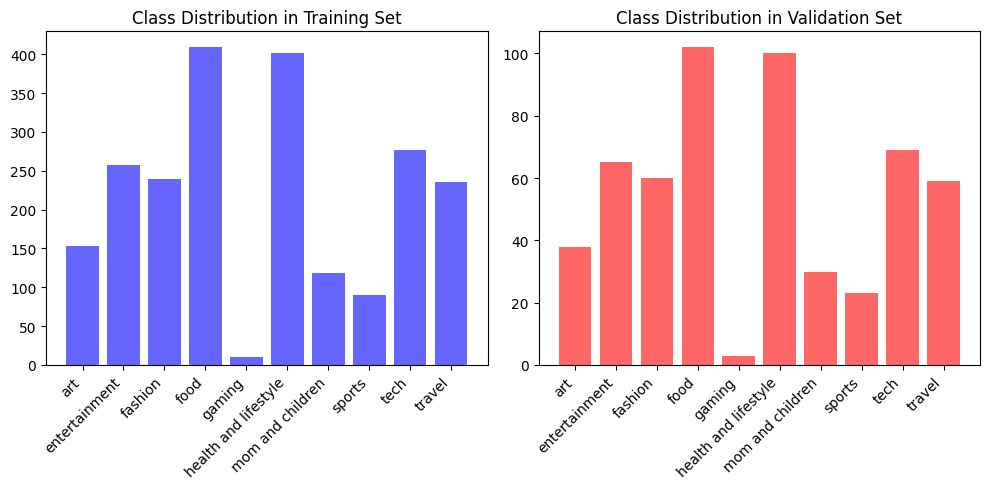


=== Preprocessing Summary ===
Training Features Shape: (2192, 10000)
Validation Features Shape: (549, 10000)
Number of Training Samples: 2192
Number of Validation Samples: 549

=== Class Distribution in Training Set ===
art: 153
entertainment: 258
fashion: 239
food: 409
gaming: 10
health and lifestyle: 402
mom and children: 119
sports: 90
tech: 277
travel: 235

=== Class Distribution in Validation Set ===
art: 38
entertainment: 65
fashion: 60
food: 102
gaming: 3
health and lifestyle: 100
mom and children: 30
sports: 23
tech: 69
travel: 59


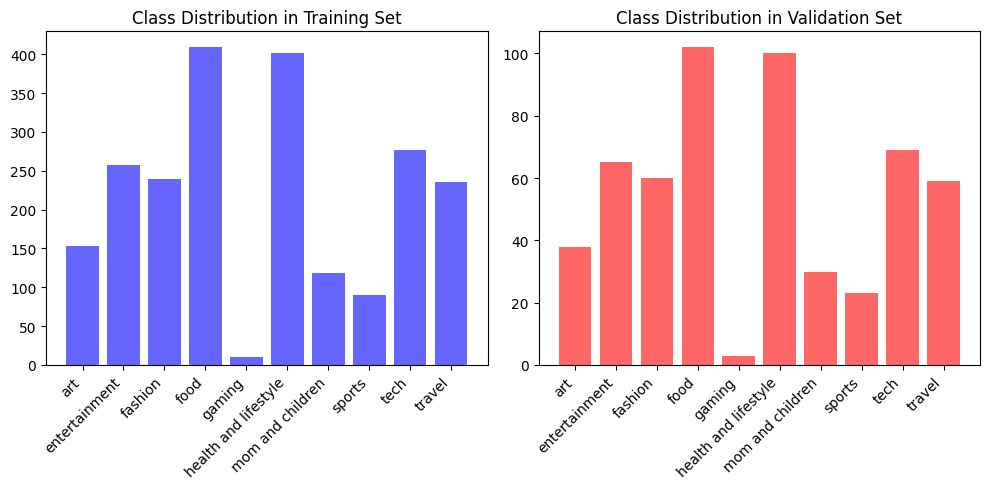

In [96]:
# Cell 14: Final Preprocessing Summary and Preparation for Modeling
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Define the label encoder for target labels
label_encoder_target = LabelEncoder()
label_encoder_target.fit(y_train_labels)

def summarize_preprocessing(x_train: csr_matrix, 
                           x_val: csr_matrix, 
                           y_train: List[int], 
                           y_val: List[int], 
                           label_encoder: LabelEncoder):
    """
    Summarizes the preprocessing steps and provides insights into the training and validation datasets.
    
    Parameters:
    - x_train: Training feature matrix.
    - x_val: Validation feature matrix.
    - y_train: Training labels.
    - y_val: Validation labels.
    - label_encoder: Fitted LabelEncoder instance for target labels.
    """
    try:
        # Print shapes of training and validation feature matrices
        print("\n=== Preprocessing Summary ===")
        print(f"Training Features Shape: {x_train.shape}")
        print(f"Validation Features Shape: {x_val.shape}")
        print(f"Number of Training Samples: {x_train.shape[0]}")
        print(f"Number of Validation Samples: {x_val.shape[0]}")
        
        # Class distribution in the training set
        print("\n=== Class Distribution in Training Set ===")
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        for cls, count in zip(unique_train, counts_train):
            print(f"{label_encoder.inverse_transform([cls])[0]}: {count}")
        
        # Class distribution in the validation set
        print("\n=== Class Distribution in Validation Set ===")
        unique_val, counts_val = np.unique(y_val, return_counts=True)
        for cls, count in zip(unique_val, counts_val):
            print(f"{label_encoder.inverse_transform([cls])[0]}: {count}")
        
        # Visualization of class distribution
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.bar(label_encoder.inverse_transform(unique_train), counts_train, color='b', alpha=0.6)
        plt.title("Class Distribution in Training Set")
        plt.xticks(rotation=45, ha='right')

        plt.subplot(1, 2, 2)
        plt.bar(label_encoder.inverse_transform(unique_val), counts_val, color='r', alpha=0.6)
        plt.title("Class Distribution in Validation Set")
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during preprocessing summary: {e}")


# Summarize preprocessing with visualization
summarize_preprocessing(x_train, x_val, y_train, y_val, label_encoder_target)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Define the label encoder for target labels
label_encoder_target = LabelEncoder()
label_encoder_target.fit(y_train_labels)

def summarize_preprocessing(x_train: csr_matrix, 
                           x_val: csr_matrix, 
                           y_train: List[int], 
                           y_val: List[int], 
                           label_encoder: LabelEncoder):
    """
    Summarizes the preprocessing steps and provides insights into the training and validation datasets.
    
    Parameters:
    - x_train: Training feature matrix.
    - x_val: Validation feature matrix.
    - y_train: Training labels.
    - y_val: Validation labels.
    - label_encoder: Fitted LabelEncoder instance for target labels.
    """
    try:
        # Print shapes of training and validation feature matrices
        print("\n=== Preprocessing Summary ===")
        print(f"Training Features Shape: {x_train.shape}")
        print(f"Validation Features Shape: {x_val.shape}")
        print(f"Number of Training Samples: {x_train.shape[0]}")
        print(f"Number of Validation Samples: {x_val.shape[0]}")
        
        # Class distribution in the training set
        print("\n=== Class Distribution in Training Set ===")
        unique_train, counts_train = np.unique(y_train, return_counts=True)
        for cls, count in zip(unique_train, counts_train):
            print(f"{label_encoder.inverse_transform([cls])[0]}: {count}")
        
        # Class distribution in the validation set
        print("\n=== Class Distribution in Validation Set ===")
        unique_val, counts_val = np.unique(y_val, return_counts=True)
        for cls, count in zip(unique_val, counts_val):
            print(f"{label_encoder.inverse_transform([cls])[0]}: {count}")
        
        # Visualization of class distribution
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.bar(label_encoder.inverse_transform(unique_train), counts_train, color='b', alpha=0.6)
        plt.title("Class Distribution in Training Set")
        plt.xticks(rotation=45, ha='right')

        plt.subplot(1, 2, 2)
        plt.bar(label_encoder.inverse_transform(unique_val), counts_val, color='r', alpha=0.6)
        plt.title("Class Distribution in Validation Set")
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during preprocessing summary: {e}")


# Summarize preprocessing with visualization
summarize_preprocessing(x_train, x_val, y_train, y_val, label_encoder_target)

# Feature Engineering

In [97]:
def add_feature_engineering(df):
    """
    Perform feature engineering on the provided DataFrame.

    Parameters:
    - df: DataFrame to add features to.

    Returns:
    - Updated DataFrame with new features.
    """
    df = df.copy()

    # Add ratios and derived features
    df['followers_to_following_ratio'] = df['follower_count'] / (df['following_count'] + 1e-5)  # Avoid division by zero
    
    # Remove posts_per_highlight since 'highlight_reel_count' was removed
    # df['posts_per_highlight'] = df['post_count'] / (df['highlight_reel_count'] + 1e-5)

    # Binary features based on thresholds
    df['is_popular'] = (df['follower_count'] > 10000).astype(int)
    df['is_active'] = (df['post_count'] > 50).astype(int)

    # Text-based features
    df['biography'] = df['biography'].astype(str)  # Ensure all values are strings
    df['biography_length'] = df['biography'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    df['has_links_in_bio'] = df['biography'].str.contains('http', na=False).astype(int)

    # Add a feature to count hashtags in biography
    df['hashtag_count_in_bio'] = df['biography'].apply(lambda x: x.count('#') if isinstance(x, str) else 0)

    return df

# Apply feature engineering to training and testing profile DataFrames
train_profile_df_engineered = add_feature_engineering(train_profile_df_encoded)
test_profile_df_engineered = add_feature_engineering(test_profile_df_encoded)

# Display results
print("Training DataFrame with Engineered Features:")
print(train_profile_df_engineered.head())

print("\nTesting DataFrame with Engineered Features:")

print(test_profile_df_engineered.head())

Training DataFrame with Engineered Features:
   username    id  full_name biography  category_name  post_count  \
0      1304  2513       1213       182            230   -0.170361   
1      2688  2096       2383      4797             53   -0.170361   
2      5160  1916       4718      1273            319   -0.170361   
3      3503  5345       3182      3105            313   -0.170361   
4      5406  5069       4903      3352            319   -0.170361   

   follower_count  following_count  is_business_account  is_private  ...  \
0       -0.052662        -0.301925                 True       False  ...   
1       -0.050889        -0.486279                 True       False  ...   
2       -0.052473        -0.025919                 True       False  ...   
3       -0.050619        -0.473638                 True       False  ...   
4       -0.051557        -0.492600                 True       False  ...   

   hide_like_and_view_counts  is_professional_account  business_category_name  \
0 

# Feature Selection and scaling

In [98]:
# Cell 16: Feature Selection and Scaling (Corrected)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# Step 1: Ensure 'post_count_bin' exists in the DataFrame
def ensure_feature_column(df, feature_name, default_value=0):
    """
    Ensures a feature column exists in the DataFrame, filling it with a default value if missing.

    Parameters:
    - df: DataFrame to check.
    - feature_name: Name of the feature column to ensure.
    - default_value: Default value to fill if the column is missing.

    Returns:
    - Updated DataFrame with the ensured feature column.
    """
    if feature_name not in df.columns:
        df[feature_name] = default_value
    # Ensure no missing values in the column
    df[feature_name] = df[feature_name].fillna(default_value)
    return df

# Ensure 'post_count_bin' exists in both training and testing DataFrames
train_profile_df_encoded = ensure_feature_column(train_profile_df_encoded, 'post_count_bin')
test_profile_df_encoded = ensure_feature_column(test_profile_df_encoded, 'post_count_bin')

# Step 2: Combine Engineered and Numerical Features
numerical_features = numerical_cols_train + ['post_count_bin']

def select_relevant_features(df, feature_columns):
    """
    Selects only the relevant features from the DataFrame.

    Parameters:
    - df: DataFrame containing the features.
    - feature_columns: List of relevant feature column names.

    Returns:
    - Selected features DataFrame.
    """
    return df[feature_columns]

# Select features from training and testing DataFrames
train_selected_features = select_relevant_features(train_profile_df_encoded, numerical_features)
test_selected_features = select_relevant_features(test_profile_df_encoded, numerical_features)

# Step 3: Apply Scaling to Numerical Features
scaler_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

def scale_features(df, pipeline):
    """
    Scales the numerical features using the provided pipeline.

    Parameters:
    - df: DataFrame containing the features to scale.
    - pipeline: Scikit-learn Pipeline for scaling.

    Returns:
    - Scaled feature matrix (numpy array).
    """
    return pipeline.fit_transform(df)

# Scale the numerical features
train_scaled_features = scale_features(train_selected_features, scaler_pipeline)
test_scaled_features = scaler_pipeline.transform(test_selected_features)

# Step 4: Combine Numerical and TF-IDF Features

# Combine numerical and TF-IDF features using hstack
x_train_combined = hstack([train_scaled_features, x_post_train])
x_test_combined = hstack([test_scaled_features, x_post_test])

# Print the final shapes for verification
print(f"Final Training Feature Matrix Shape: {x_train_combined.shape}")
print(f"Final Testing Feature Matrix Shape: {x_test_combined.shape}")

# Outputs are now ready for model training and evaluation.


Final Training Feature Matrix Shape: (2741, 10004)
Final Testing Feature Matrix Shape: (2674, 10004)


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from scipy.sparse import hstack, csr_matrix
import time

# Step 1: Split Data into Training and Validation Sets
x_train, x_val, y_train, y_val = train_test_split(
    x_post_train,          # Optimized TF-IDF features
    y_train_encoded,       # Encoded target labels
    test_size=0.2,         # 20% for validation
    random_state=42,       # Seed for reproducibility
    stratify=y_train_encoded  # Maintain class distribution
)

# Step 2: Apply SMOTE to the Training Set
print("\nApplying SMOTE to balance the training data...")
smote = SMOTE(random_state=42)

# SMOTE requires dense arrays, so convert sparse matrices to dense temporarily
x_train_dense = x_train.toarray()  # Convert sparse matrix to dense
x_train_smote, y_train_smote = smote.fit_resample(x_train_dense, y_train)

# Convert SMOTE-transformed features back to sparse format
x_train_smote_sparse = csr_matrix(x_train_smote)

print(f"Original Training Set Size: {x_train.shape[0]} samples")
print(f"Balanced Training Set Size with SMOTE: {x_train_smote_sparse.shape[0]} samples")

# Step 3: Train Logistic Regression Model with Progress Bar
baseline_model = LogisticRegression(max_iter=1000, random_state=42)

# Initialize tqdm progress bar
with tqdm(total=100, desc="Training Logistic Regression", unit="%") as pbar:
    start_time = time.time()
    baseline_model.fit(x_train_smote_sparse, y_train_smote)  # Train the model
    end_time = time.time()
    pbar.update(100)  # Training completed, update progress bar to 100%
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Step 4: Evaluate Model on Training Set
y_train_pred = baseline_model.predict(x_train_smote_sparse)
train_accuracy = accuracy_score(y_train_smote, y_train_pred)
print(f"\n=== Training Evaluation ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print("\nTraining Classification Report:")
print(classification_report(y_train_smote, y_train_pred, zero_division=0))

# Step 5: Evaluate Model on Validation Set
y_val_pred = baseline_model.predict(x_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\n=== Validation Evaluation ===")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred, zero_division=0))


Applying SMOTE to balance the training data...
Original Training Set Size: 2192 samples
Balanced Training Set Size with SMOTE: 4090 samples


Training Logistic Regression: 100%|██████████| 100/100 [00:00<00:00, 166.74%/s]

Training completed in 0.60 seconds.

=== Training Evaluation ===
Training Accuracy: 0.8032

Training Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.65      0.75       409
           1       0.83      0.61      0.70       409
           2       0.71      0.87      0.78       409
           3       0.85      0.84      0.84       409
           4       1.00      1.00      1.00       409
           5       0.73      0.63      0.67       409
           6       0.77      0.91      0.83       409
           7       0.89      0.95      0.92       409
           8       0.76      0.85      0.80       409
           9       0.67      0.74      0.70       409

    accuracy                           0.80      4090
   macro avg       0.81      0.80      0.80      4090
weighted avg       0.81      0.80      0.80      4090


=== Validation Evaluation ===
Validation Accuracy: 0.5902

Validation Classification Report:
              precision

In [100]:
import numpy as np
import pandas as pd

# Step 1: Extract Coefficients from the Model
coefficients = baseline_model.coef_  # Shape: (num_classes, num_features)

# Step 2: Map Coefficients to Features
# Combine numerical and TF-IDF feature names
numerical_feature_names = train_selected_features.columns.tolist()  # Assuming these are numerical features
tfidf_feature_names = vectorizer_pipeline.named_steps['tfidf'].get_feature_names_out()

# Combine all feature names
all_feature_names = numerical_feature_names + tfidf_feature_names.tolist()

# Check if the lengths match
assert len(all_feature_names) == coefficients.shape[1], "Mismatch between features and coefficients!"

# Step 3: Create a DataFrame for Feature Importance
importance_df = pd.DataFrame(coefficients.T, index=all_feature_names)
importance_df.columns = label_encoder_target.classes_  # Class names as columns

# Step 4: Analyze Feature Importance
# Example: Top 10 important features for each class
for class_label in importance_df.columns:
    print(f"\n=== Top 10 Features for Class: {class_label} ===")
    top_features = importance_df[class_label].abs().sort_values(ascending=False).head(10)
    print(top_features)

# Optional: Save feature importance to a CSV for deeper analysis
importance_df.to_csv("feature_importance.csv", index=True)


=== Top 10 Features for Class: art ===
tiyatro           3.464124
art               3.239028
sanat             2.204986
kırtasiye         1.942233
biletler          1.894780
interiordesign    1.845811
kitap             1.682428
design            1.494089
içmimar           1.482214
kitabı            1.441296
Name: art, dtype: float64

=== Top 10 Features for Class: entertainment ===
eğlence     2.270840
sahne       2.161788
müzik       1.688661
konser      1.601983
biletix     1.576063
bölüm       1.536817
izmir       1.500108
akşam       1.427816
film        1.384441
etkinlik    1.375824
Name: entertainment, dtype: float64

=== Top 10 Features for Class: fashion ===
fashion       2.225632
style         2.047706
styling       2.014331
collection    1.986565
pırlanta      1.912361
şık           1.826266
cotton        1.807933
fw            1.501151
yenisezon     1.456206
ayar          1.390847
Name: fashion, dtype: float64

=== Top 10 Features for Class: food ===
lezzet            4.213

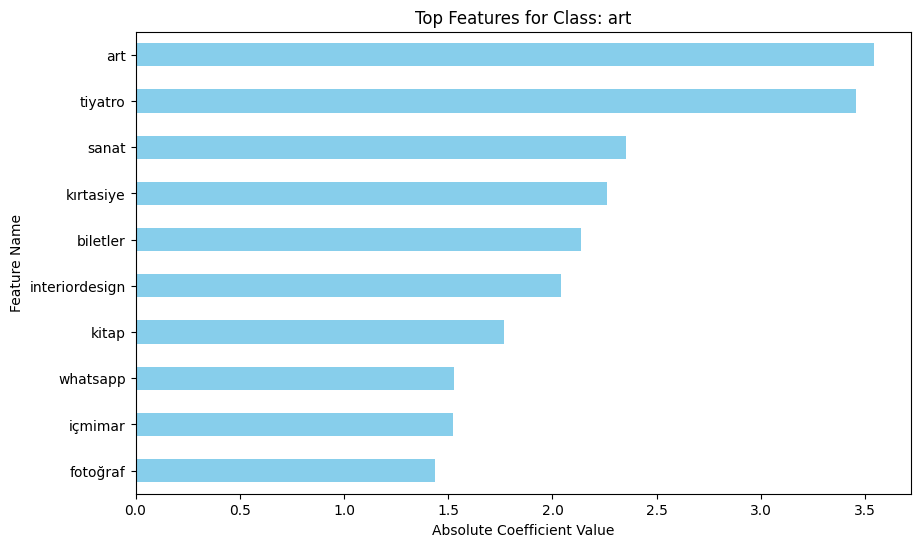

In [90]:
import matplotlib.pyplot as plt

# Example: Bar chart for a specific class
class_to_plot = label_encoder_target.classes_[0]  # Change this for other classes
top_features = importance_df[class_to_plot].abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind="barh", color="skyblue")
plt.title(f"Top Features for Class: {class_to_plot}")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature Name")
plt.gca().invert_yaxis()  # Invert to show the largest feature on top
plt.show()


# Improving Model

# Regresion Task


In [91]:
# Cell 20: Regression Task - Predicting Like Count

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import numpy as np
import time

# Step 1: Prepare Data for Regression
def prepare_regression_data(username_to_posts: dict, feature_matrix: csr_matrix, preprocess_fn) -> (np.ndarray, np.ndarray):
    """
    Prepares data for the regression task by extracting features and target values.
    
    Parameters:
    - username_to_posts: Dictionary mapping usernames to their posts.
    - feature_matrix: Pre-computed feature matrix (e.g., TF-IDF and numerical features).
    - preprocess_fn: Function for text preprocessing.
    
    Returns:
    - features: Feature matrix for regression (e.g., combined features).
    - targets: Target values (e.g., average like counts).
    """
    targets = []
    indices_to_remove = []  # To track rows with NaN targets

    for i, (username, posts) in enumerate(username_to_posts.items()):
        # Calculate average like count for the user
        avg_likes = np.mean([post.get("like_count", 0) or 0 for post in posts])
        if np.isnan(avg_likes):
            indices_to_remove.append(i)  # Mark index for removal
        else:
            targets.append(avg_likes)

    # Remove rows with NaN targets from the feature matrix
    feature_matrix = np.delete(feature_matrix.toarray(), indices_to_remove, axis=0)
    
    return feature_matrix, np.array(targets)


# Prepare training data
x_reg_train, y_reg_train = prepare_regression_data(username2posts_train, x_train_combined, preprocess_text)

# Prepare testing data (if needed for evaluation)
x_reg_test, y_reg_test = prepare_regression_data(username2posts_test, x_test_combined, preprocess_text)

print(f"Regression Training Features Shape: {x_reg_train.shape}")
print(f"Regression Training Targets Shape: {y_reg_train.shape}")

# Step 2: Define a Baseline Regression Model
baseline_regressor = LinearRegression()

# Step 3: Train Regression Model with Progress Bar
with tqdm(total=100, desc="Training Linear Regression", unit="%") as pbar:
    start_time = time.time()
    baseline_regressor.fit(x_reg_train, y_reg_train)
    end_time = time.time()
    pbar.update(100)  # Training completed
    print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Step 4: Evaluate the Model
# Training Evaluation
y_train_pred = baseline_regressor.predict(x_reg_train)
train_mse = mean_squared_error(y_reg_train, y_train_pred)
train_rmse = np.sqrt(train_mse)

print("\n=== Training Evaluation ===")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")

# Testing Evaluation (if available)
if y_reg_test.size > 0:
    y_test_pred = baseline_regressor.predict(x_reg_test)
    test_mse = mean_squared_error(y_reg_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    print("\n=== Testing Evaluation ===")
    print(f"Testing MSE: {test_mse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")

# Step 5: Save Results
# Optional: Save predictions for further analysis
regression_results = {
    "y_train_true": y_reg_train.tolist(),
    "y_train_pred": y_train_pred.tolist(),
    "y_test_true": y_reg_test.tolist() if y_reg_test.size > 0 else [],
    "y_test_pred": y_test_pred.tolist() if y_reg_test.size > 0 else []
}

print("\nRegression Results Saved for Analysis!")

c:\Users\itsmm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\itsmm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Regression Training Features Shape: (2739, 5004)
Regression Training Targets Shape: (2739,)


Training Linear Regression: 100%|██████████| 100/100 [00:06<00:00, 15.85%/s]

Training completed in 6.31 seconds.

=== Training Evaluation ===
Training MSE: 1358.2981
Training RMSE: 36.8551

=== Testing Evaluation ===
Testing MSE: 2297725452961638106817101824.0000
Testing RMSE: 47934595575238.1250

Regression Results Saved for Analysis!


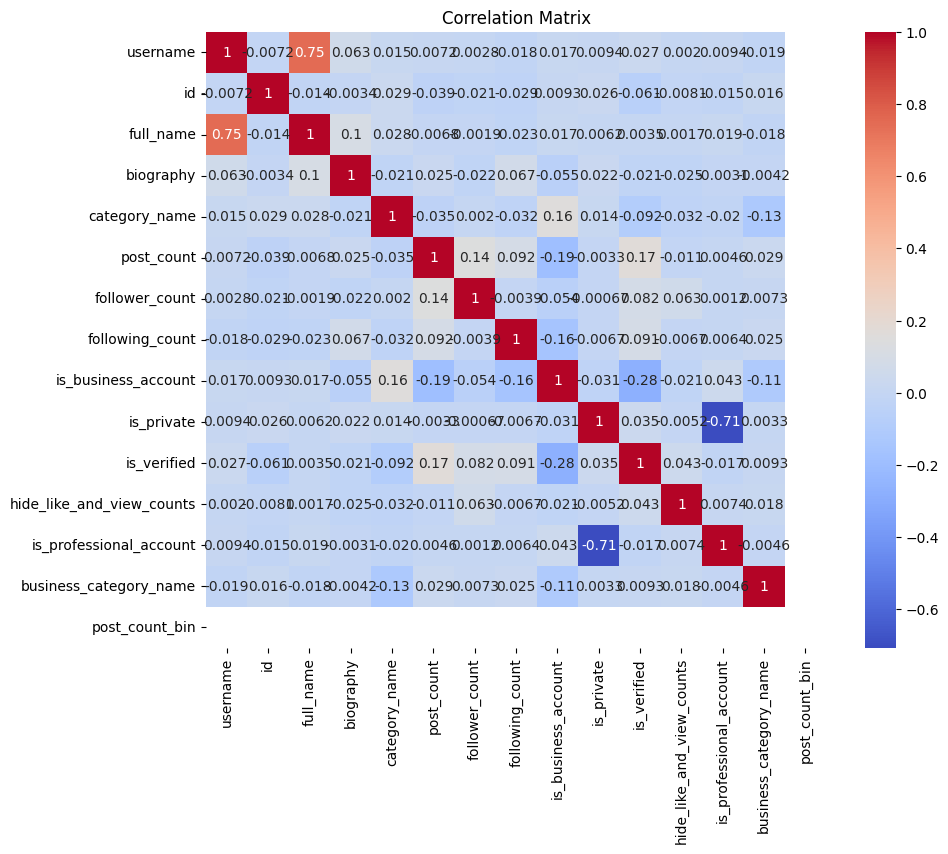

Original Features: 4
Features After Removing Low Variance: 3


In [92]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold

# Analyze correlation among numerical features
correlation_matrix = train_profile_df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Identify low-variance features
selector = VarianceThreshold(threshold=0.01)  # Set a low threshold for variance
high_variance_features = selector.fit_transform(train_scaled_features)

print(f"Original Features: {train_scaled_features.shape[1]}")
print(f"Features After Removing Low Variance: {high_variance_features.shape[1]}")
